# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

## Bibliotecas

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)

## Dados

In [9]:
prison = pd.read_csv("data.csv")

In [21]:
prison.head(6)

(        week  volume
 0 2022-10-31    0.33
 1 2022-11-07    0.47
 2 2022-11-14    0.32
 3 2022-11-21    1.69
 4 2022-11-28    1.23
 5 2022-12-05    0.77,
           week  volume
 144 2025-08-04   13.43
 145 2025-08-11   13.60
 146 2025-08-18   15.20
 147 2025-08-25   16.24
 148 2025-09-01   13.43
 149 2025-09-08   16.59)

In [22]:
prison.tail(6)

,week,volume
144,2025-08-04,13.43
145,2025-08-11,13.60
146,2025-08-18,15.20
147,2025-08-25,16.24
148,2025-09-01,13.43
149,2025-09-08,16.59


In [11]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

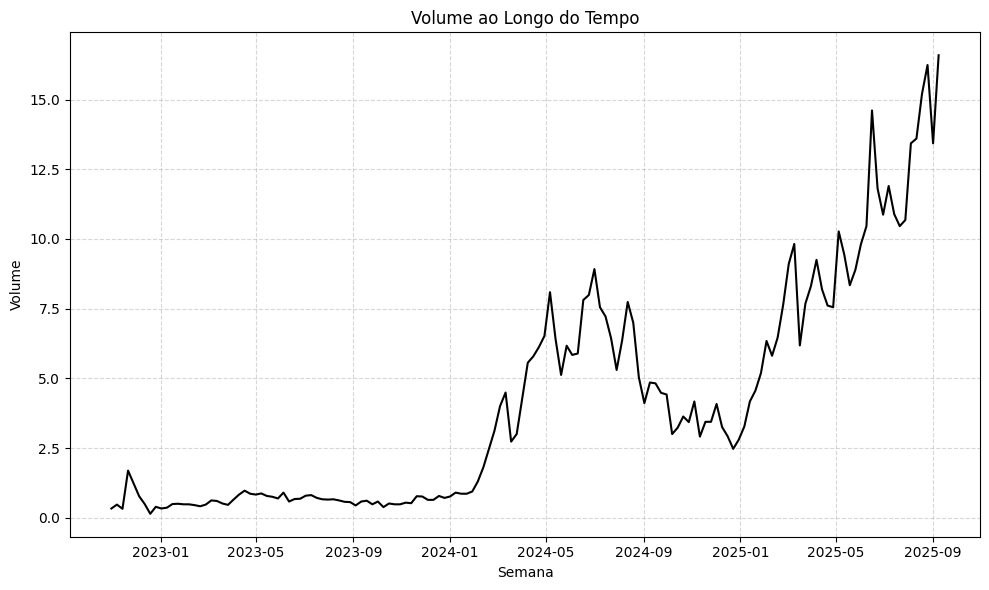

In [12]:
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(prison["week"], prison["volume"], linestyle='-', marker='', color='black')

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Baselines

In [17]:
# série semanal com frequência explícita
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte (altere para 4 se quiser curto prazo)
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal
    "drift": fit_pred("drift", sp=1),
}

mase_metric = MeanAbsoluteScaledError(sp=52)

rows = []
for name, yhat in preds.items():
    rows.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    })

metrics_sktime = pd.DataFrame(rows).sort_values("RMSE")
metrics_sktime

,model,MAE,RMSE,MAPE_%,MASE
3,drift,2.893644,3.671492,39.181832,0.836418
2,snaive,4.082692,4.621097,59.578569,1.180117
1,naive,3.762692,4.856629,44.401822,1.087620
0,mean,5.484937,6.747853,61.471615,1.585441
